## Importing libraries

In [350]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

## Reading the dataset

In [351]:
data = pd.read_csv('used_cars_data.csv')
data.head()

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


- The S.No. is simply a row identifier which can be removed.
- The Name is long string comprising the Brand, Model and addition specification. These can be split to further analyse by make and model.
- The Fuel_Type, Transmission and Owner_Type are categorical variable which can be possibly be one-hot encoded.
- Mileage, Engine and Power are strings leading with number and unit. These shall be split and numerical portion will be used in analysis.

In [352]:
data = data.drop(columns=['S.No.'])
data.columns = [col.lower() for col in data.columns] # column names converted to lower case for ease of use

## Shape of the dataset

In [353]:
data.shape
print(f"The Dataframe consists of '{data.shape[0]}' rows and '{data.shape[1]}' columns")

The Dataframe consists of '7253' rows and '13' columns


In [354]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               7253 non-null   object 
 1   location           7253 non-null   object 
 2   year               7253 non-null   int64  
 3   kilometers_driven  7253 non-null   int64  
 4   fuel_type          7253 non-null   object 
 5   transmission       7253 non-null   object 
 6   owner_type         7253 non-null   object 
 7   mileage            7251 non-null   object 
 8   engine             7207 non-null   object 
 9   power              7207 non-null   object 
 10  seats              7200 non-null   float64
 11  new_price          1006 non-null   object 
 12  price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 736.8+ KB


There seems to be some missing values in a few columns.

## Checking for duplicates

In [355]:
data.duplicated().sum()

1

In [356]:
data.drop_duplicates(inplace=True)

print(f"The Dataframe now consists of '{data.shape[0]}' rows and '{data.shape[1]}' columns")

The Dataframe now consists of '7252' rows and '13' columns


## Checking for missing values

In [357]:
data.isnull().sum()

name                    0
location                0
year                    0
kilometers_driven       0
fuel_type               0
transmission            0
owner_type              0
mileage                 2
engine                 46
power                  46
seats                  53
new_price            6246
price                1233
dtype: int64

There a lot of missing values that need to be dealt with.

## Data Summary

In [358]:
data.describe()

,year,kilometers_driven,seats,price
count,7252.000000,7.252000e+03,7199.000000,6019.000000
mean,2013.365830,5.869999e+04,5.279761,9.479468
std,3.254405,8.443351e+04,0.811709,11.187917
min,1996.000000,1.710000e+02,0.000000,0.440000
25%,2011.000000,3.400000e+04,5.000000,3.500000
50%,2014.000000,5.342900e+04,5.000000,5.640000
75%,2016.000000,7.300000e+04,5.000000,9.950000
max,2019.000000,6.500000e+06,10.000000,160.000000


## EDA & Feature Engineering

### name column

In [359]:
data["make"] = data["name"].str.split(" ").str[0]
data["model"] = data["name"].str.split(" ").str[1]

In [360]:
data["make"].value_counts()

make
Maruti           1444
Hyundai          1340
Honda             742
Toyota            507
Mercedes-Benz     380
Volkswagen        374
Ford              351
Mahindra          331
BMW               312
Audi              285
Tata              228
Skoda             202
Renault           170
Chevrolet         151
Nissan            117
Land               67
Jaguar             48
Fiat               38
Mitsubishi         36
Mini               31
Volvo              28
Porsche            19
Jeep               19
Datsun             17
ISUZU               3
Force               3
Isuzu               2
Bentley             2
Smart               1
Ambassador          1
Lamborghini         1
Hindustan           1
OpelCorsa           1
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='make'>

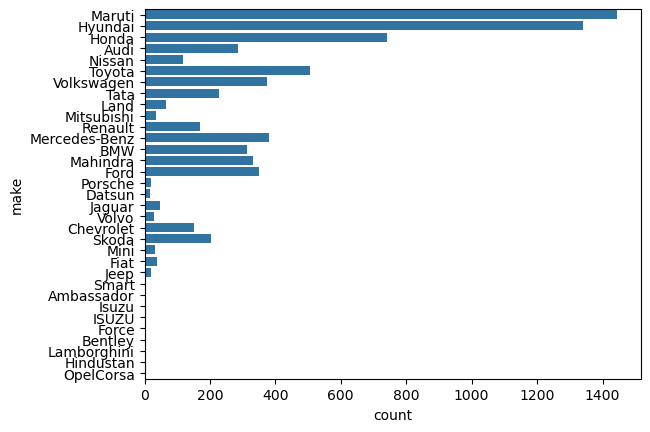

In [361]:
sns.countplot(data["make"])

There are 33 different car brands of which MARUTI is the most popular.

In [362]:
data["model"].value_counts()

model
Swift        418
City         317
i20          303
Innova       203
Verna        200
            ... 
CLS-Class      1
Redi           1
E              1
Evalia         1
1.4Gsi         1
Name: count, Length: 219, dtype: int64

The dataset has 219 different car models out of which SWIFT is the most popular.

### location column

In [363]:
data["location"].value_counts()

location
Mumbai        948
Hyderabad     876
Coimbatore    772
Kochi         772
Pune          765
Delhi         660
Kolkata       654
Chennai       591
Jaipur        499
Bangalore     440
Ahmedabad     275
Name: count, dtype: int64

Mumbai is the most popular and Ahmedabad is the least popular location.

In [364]:
# Grouping locations into regions
region_mapping = {
    'Chennai': 'South',
    'Jaipur': 'North',
    'Pune': 'West',
    'Mumbai': 'West',
    'Kolkata': 'East',
    'Delhi': 'North',
    'Ahmedabad': 'West',
    'Hyderabad': 'South',
    'Coimbatore': 'South',
    'Bangalore': 'South',
    'Kochi': 'South'
}

data['region'] = data['location'].map(region_mapping)

<Axes: ylabel='count'>

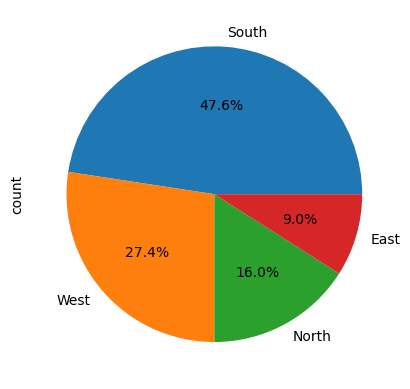

In [365]:
data["region"].value_counts().plot(kind="pie", autopct="%1.1f%%")

### year column

In [366]:
data["year"].value_counts()

year
2015    929
2014    925
2016    886
2013    791
2017    709
2012    690
2011    579
2010    406
2018    361
2009    252
2008    207
2007    148
2019    119
2006     89
2005     68
2004     35
2003     20
2002     18
2001      8
2000      5
1998      4
1999      2
1996      1
Name: count, dtype: int64

There are 23 different years of manufacture of which 2015 is the most popular and 1996 is the least popular.

In [367]:
data["car_age"] = 2019 - data["year"] # since the dataset is from 2019
data["car_age"].value_counts()

car_age
4     929
5     925
3     886
6     791
2     709
7     690
8     579
9     406
1     361
10    252
11    207
12    148
0     119
13     89
14     68
15     35
16     20
17     18
18      8
19      5
21      4
20      2
23      1
Name: count, dtype: int64

The most popular used car is 4 years old while the oldest used car age is 23 years old.

### kilometers_driven

<Axes: xlabel='kilometers_driven'>

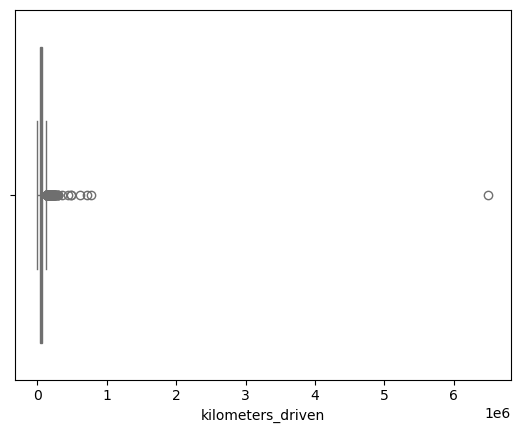

In [368]:
sns.boxplot(x=data["kilometers_driven"], color="skyblue")

In [369]:
data[data["kilometers_driven"] == data["kilometers_driven"].max()]

,name,location,year,kilometers_driven,fuel_type,transmission,owner_type,mileage,engine,power,seats,new_price,price,make,model,region,car_age
2328,BMW X5 xDrive 30d M Sport,Chennai,2017,6500000,Diesel,Automatic,First,15.97 kmpl,2993 CC,258 bhp,5.0,NaN,65.0,BMW,X5,South,2


In [370]:
data = data.drop(index=data[data["kilometers_driven"] == data["kilometers_driven"].max()].index)

<Axes: xlabel='kilometers_driven'>

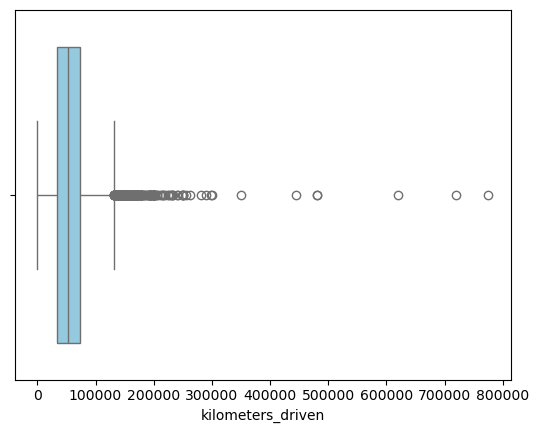

In [371]:
sns.boxplot(x=data["kilometers_driven"], color="skyblue")

### fuel_type column

In [372]:
data["fuel_type"].value_counts()

fuel_type
Diesel      3851
Petrol      3324
CNG           62
LPG           12
Electric       2
Name: count, dtype: int64

Diesel and Petrol are the most popular fuel types.

### transmission column

In [373]:
data["transmission"].value_counts()

transmission
Manual       5203
Automatic    2048
Name: count, dtype: int64

### owner_type column

In [374]:
data["owner_type"].value_counts()

owner_type
First             5950
Second            1152
Third              137
Fourth & Above      12
Name: count, dtype: int64

First owner is the most popular type.

### mileage column

In [375]:
split_mileage = data["mileage"].str.split(' ', expand=True)
data["mileage"] = split_mileage[0]
data['mileage'] = pd.to_numeric(data["mileage"], errors='coerce')
data["mileage_unit"] = split_mileage[1]
data.sample(1)

,name,location,year,kilometers_driven,fuel_type,transmission,owner_type,mileage,engine,power,seats,new_price,price,make,model,region,car_age,mileage_unit
6626,Honda Amaze S i-Dtech,Kolkata,2013,51637,Diesel,Manual,First,25.8,1498 CC,98.6 bhp,5.0,NaN,NaN,Honda,Amaze,East,6,kmpl


In [376]:
data["mileage_unit"].value_counts()

mileage_unit
kmpl     7175
km/kg      74
Name: count, dtype: int64

The km/kg accounts for ~1% of the dataset.

### engine column

In [377]:
data["engine"] = data["engine"].str.split(' ').str[0]
data['engine'] = pd.to_numeric(data["engine"], errors='coerce')

### power column

In [378]:
data["power"] = data["power"].str.split(' ').str[0]
data['power'] = pd.to_numeric(data["power"], errors='coerce')

### seats column

In [379]:
data["seats"].value_counts()

seats
5.0     6045
7.0      796
8.0      170
4.0      119
6.0       38
2.0       18
10.0       8
9.0        3
0.0        1
Name: count, dtype: int64

In [380]:
data = data[data["seats"]!= 0]  # Removing rows with 0 seats as they are not valid cars

### new_price column

In [381]:
data["new_price"].isnull().sum()

6244

In [382]:
# Dropping new_price column since more than 60% of the values are missing
data.drop(columns= ["new_price"], inplace=True)  

### price column

In [383]:
data["price"].isnull().sum()

1233

Since it is the target variable, we cannot simply impute the missing values. Thus, we shall drop rows corresponding to null value in the price column.

In [384]:
data.dropna(subset=['price'], inplace=True)

### Checking data after preprocessing

In [385]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6017 entries, 0 to 6018
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               6017 non-null   object 
 1   location           6017 non-null   object 
 2   year               6017 non-null   int64  
 3   kilometers_driven  6017 non-null   int64  
 4   fuel_type          6017 non-null   object 
 5   transmission       6017 non-null   object 
 6   owner_type         6017 non-null   object 
 7   mileage            6015 non-null   float64
 8   engine             5981 non-null   float64
 9   power              5875 non-null   float64
 10  seats              5975 non-null   float64
 11  price              6017 non-null   float64
 12  make               6017 non-null   object 
 13  model              6017 non-null   object 
 14  region             6017 non-null   object 
 15  car_age            6017 non-null   int64  
 16  mileage_unit       6015 non-n

In [386]:
data.describe()

,year,kilometers_driven,mileage,engine,power,seats,price,car_age
count,6017.000000,6017.000000,6015.000000,5981.000000,5875.000000,5975.000000,6017.000000,6017.000000
mean,2013.357820,57656.857404,18.136590,1620.783648,113.228412,5.279665,9.468825,5.642180
std,3.269902,37871.981705,4.581908,600.848537,53.846427,0.806078,11.166312,3.269902
min,1998.000000,171.000000,0.000000,72.000000,34.200000,2.000000,0.440000,0.000000
25%,2011.000000,34000.000000,15.170000,1198.000000,75.000000,5.000000,3.500000,3.000000
50%,2014.000000,53000.000000,18.160000,1493.000000,97.700000,5.000000,5.640000,5.000000
75%,2016.000000,73000.000000,21.100000,1984.000000,138.100000,5.000000,9.950000,8.000000
max,2019.000000,775000.000000,33.540000,5998.000000,560.000000,10.000000,160.000000,21.000000


- mileage - The min value of 0 implies that the manufacturer supplied mileage stats was not input into the dataset.
- engine - The min value of 72 appears to an outlier and not realistic for car engine size. This will be dealt with later on.

### mileage column revisited
The mileage column has been observed to have a minimum of 0. This implies that the manufacturer supplied mileage stats were not input into the dataset.

In [387]:
data[data["mileage"] == 0]

,name,location,year,kilometers_driven,fuel_type,transmission,owner_type,mileage,engine,power,seats,price,make,model,region,car_age,mileage_unit
14,Land Rover Freelander 2 TD4 SE,Pune,2012,85000,Diesel,Automatic,Second,0.0,2179.0,115.0,5.0,17.50,Land,Rover,West,7,kmpl
67,Mercedes-Benz C-Class Progressive C 220d,Coimbatore,2019,15369,Diesel,Automatic,First,0.0,1950.0,194.0,5.0,35.67,Mercedes-Benz,C-Class,South,0,kmpl
79,Hyundai Santro Xing XL,Hyderabad,2005,87591,Petrol,Manual,First,0.0,1086.0,NaN,5.0,1.30,Hyundai,Santro,South,14,kmpl
194,Honda City 1.5 GXI,Ahmedabad,2007,60006,Petrol,Manual,First,0.0,NaN,NaN,NaN,2.95,Honda,City,West,12,kmpl
229,Ford Figo Diesel,Bangalore,2015,70436,Diesel,Manual,First,0.0,1498.0,99.0,NaN,3.60,Ford,Figo,South,4,kmpl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5647,Toyota Qualis Fleet A3,Mumbai,2001,227000,Diesel,Manual,Fourth & Above,0.0,2446.0,NaN,8.0,2.20,Toyota,Qualis,West,18,kmpl
5875,Mercedes-Benz C-Class Progressive C 220d,Ahmedabad,2019,4000,Diesel,Automatic,First,0.0,1950.0,194.0,5.0,35.00,Mercedes-Benz,C-Class,West,0,kmpl
5943,Mahindra Jeep MM 540 DP,Chennai,2002,75000,Diesel,Manual,First,0.0,2112.0,NaN,6.0,1.70,Mahindra,Jeep,South,17,kmpl
5972,Hyundai Santro Xing GL,Mumbai,2008,65000,Petrol,Manual,Second,0.0,1086.0,62.0,5.0,1.39,Hyundai,Santro,West,11,kmpl


 Since this incorrect value of 0 will affect the analysis let replace 0 with NaN.

In [388]:
data["mileage"].replace(to_replace=0, value= np.nan, inplace=True)

## Missing value imputation

In [389]:
data.isnull().sum()

name                   0
location               0
year                   0
kilometers_driven      0
fuel_type              0
transmission           0
owner_type             0
mileage               70
engine                36
power                142
seats                 42
price                  0
make                   0
model                  0
region                 0
car_age                0
mileage_unit           2
dtype: int64

It is possible to impute the missing values of the engine, seats, power and mileage by comparing like for like car names where the values are available in the dataset.

In [390]:
# Temporary column that will be deleted later on
data['car_name'] = data[['make', 'model']].apply(lambda x: ' '.join(x), axis=1)

### power column

In [391]:
# Fill missing power with the mean power for that car_name
data["power"] = data.groupby("car_name")["power"].transform(lambda x: x.fillna(x.mean()))

In [392]:
data["power"].isnull().sum()
# Still there are 11 data points with missing power values, we will drop them

11

In [393]:
data = data.dropna(subset=['power'])

### mileage column

In [394]:
data["mileage"] = data.groupby("car_name")["mileage"].transform(lambda x: x.fillna(x.mean()))

In [395]:
data["mileage"].isnull().sum()

5

In [396]:
data[data["mileage"].isnull()]

,name,location,year,kilometers_driven,fuel_type,transmission,owner_type,mileage,engine,power,seats,price,make,model,region,car_age,mileage_unit,car_name
67,Mercedes-Benz C-Class Progressive C 220d,Coimbatore,2019,15369,Diesel,Automatic,First,NaN,1950.0,194.0,5.0,35.67,Mercedes-Benz,C-Class,South,0,kmpl,Mercedes-Benz C-Class
962,Mercedes-Benz C-Class Progressive C 220d,Mumbai,2018,8682,Diesel,Automatic,First,NaN,1950.0,194.0,5.0,39.50,Mercedes-Benz,C-Class,West,1,kmpl,Mercedes-Benz C-Class
4446,Mahindra E Verito D4,Chennai,2016,50000,Electric,Automatic,First,NaN,72.0,41.0,5.0,13.00,Mahindra,E,South,3,NaN,Mahindra E
4904,Toyota Prius 2009-2016 Z4,Mumbai,2011,44000,Electric,Automatic,First,NaN,1798.0,73.0,5.0,12.75,Toyota,Prius,West,8,NaN,Toyota Prius
5875,Mercedes-Benz C-Class Progressive C 220d,Ahmedabad,2019,4000,Diesel,Automatic,First,NaN,1950.0,194.0,5.0,35.00,Mercedes-Benz,C-Class,West,0,kmpl,Mercedes-Benz C-Class


In [397]:
data = data.dropna(subset=['mileage'])

### seats column

In [398]:
data["seats"] = data.groupby("car_name")["seats"].transform(lambda x: x.fillna(x.mean()))

In [399]:
data["seats"].isnull().sum()

0

### engine column

In [400]:
data["engine"] = data.groupby("car_name")["engine"].transform(lambda x: x.fillna(x.mean()))

In [401]:
data["engine"].isnull().sum()

0

In [402]:
# info of the dataframe after cleaning
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6001 entries, 0 to 6018
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               6001 non-null   object 
 1   location           6001 non-null   object 
 2   year               6001 non-null   int64  
 3   kilometers_driven  6001 non-null   int64  
 4   fuel_type          6001 non-null   object 
 5   transmission       6001 non-null   object 
 6   owner_type         6001 non-null   object 
 7   mileage            6001 non-null   float64
 8   engine             6001 non-null   float64
 9   power              6001 non-null   float64
 10  seats              6001 non-null   float64
 11  price              6001 non-null   float64
 12  make               6001 non-null   object 
 13  model              6001 non-null   object 
 14  region             6001 non-null   object 
 15  car_age            6001 non-null   int64  
 16  mileage_unit       6001 non-n

In [403]:
data.describe()

,year,kilometers_driven,mileage,engine,power,seats,price,car_age
count,6001.000000,6001.000000,6001.000000,6001.000000,6001.000000,6001.000000,6001.000000,6001.000000
mean,2013.367939,57679.763373,18.322599,1620.031973,112.616977,5.280155,9.454309,5.632061
std,3.253347,37874.166625,4.165335,599.474062,53.707185,0.801404,11.145140,3.253347
min,1998.000000,171.000000,6.400000,624.000000,34.200000,2.000000,0.440000,0.000000
25%,2011.000000,34000.000000,15.300000,1198.000000,75.000000,5.000000,3.500000,3.000000
50%,2014.000000,53000.000000,18.160000,1493.000000,93.700000,5.000000,5.640000,5.000000
75%,2016.000000,73000.000000,21.100000,1984.000000,138.100000,5.000000,9.950000,8.000000
max,2019.000000,775000.000000,33.540000,5998.000000,560.000000,10.000000,160.000000,21.000000


## Univariate analysis

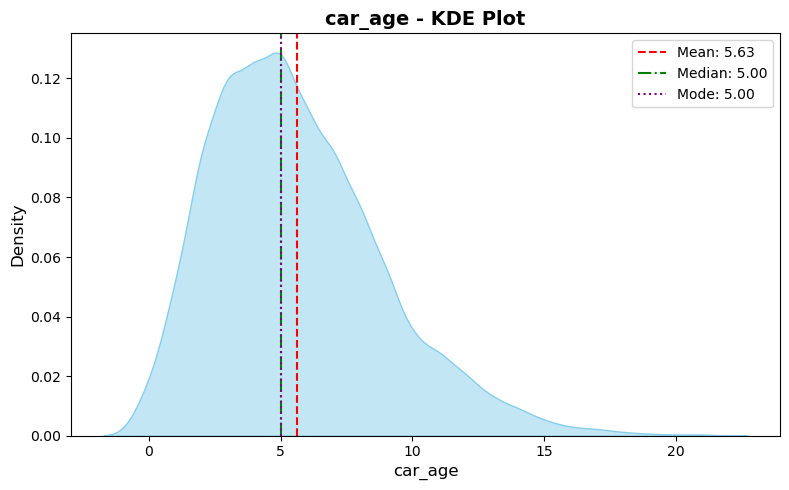

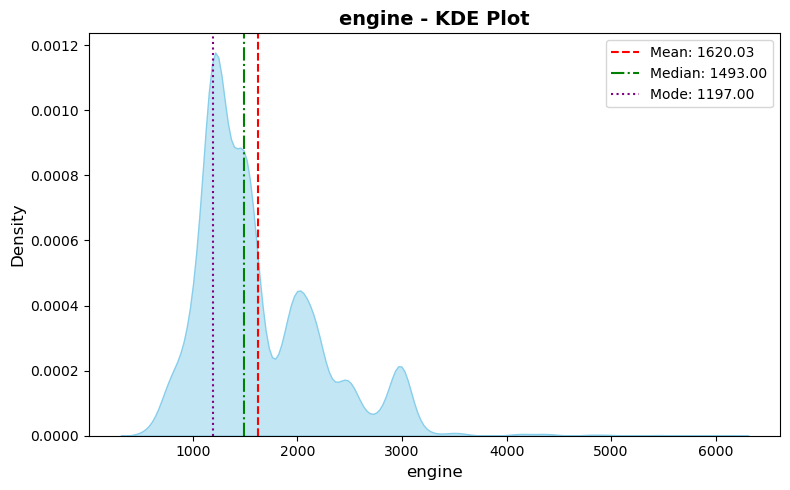

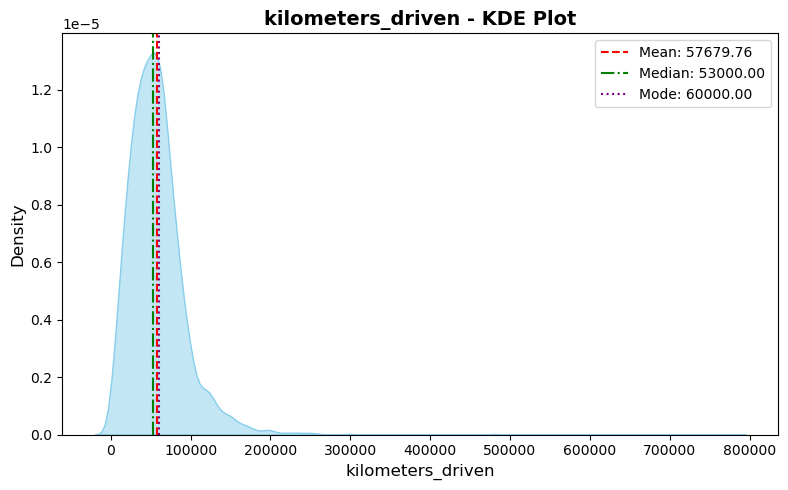

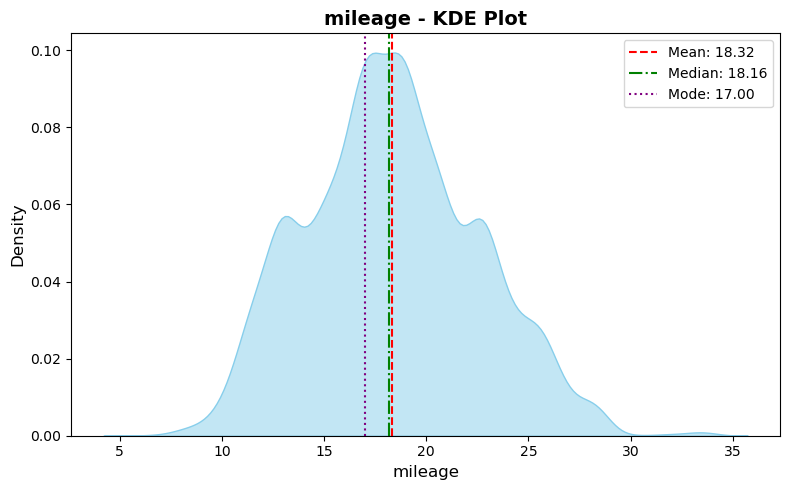

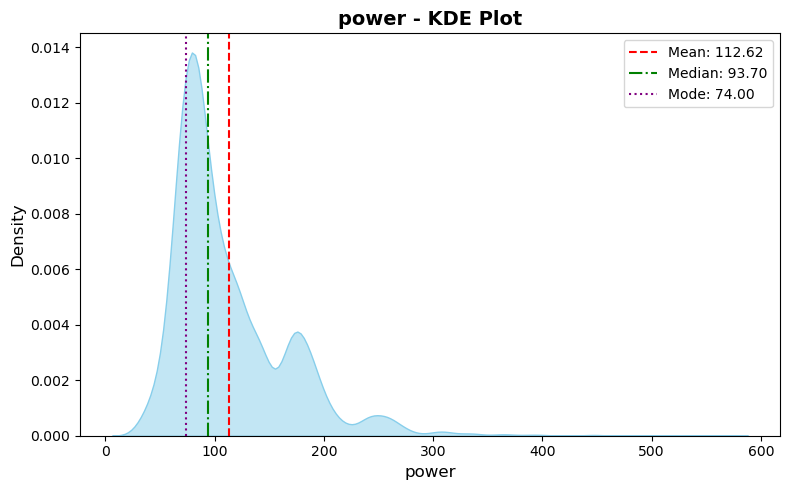

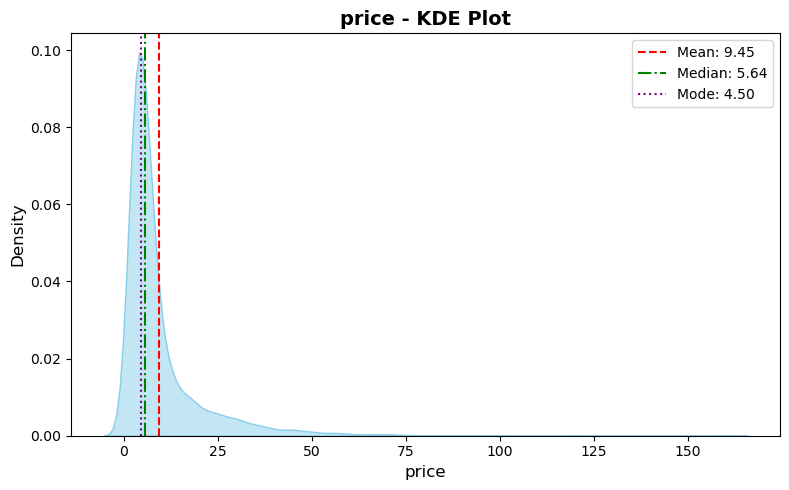

In [404]:
num_cols = ['car_age', 'engine', 'kilometers_driven', 'mileage', 'power', 'price']

for col in num_cols:
    plt.figure(figsize=(8, 5))
    
    sns.kdeplot(data[col].dropna(), fill=True, color="skyblue", alpha=0.5)
    
    # Mean, median, and mode
    mean_val = data[col].mean()
    median_val = data[col].median()
    mode_val = data[col].mode()[0]
    plt.axvline(mean_val, color="red", linestyle="--", linewidth=1.5, label=f"Mean: {mean_val:.2f}")
    plt.axvline(median_val, color="green", linestyle="-.", linewidth=1.5, label=f"Median: {median_val:.2f}")
    plt.axvline(mode_val, color="purple", linestyle=":", linewidth=1.5, label=f"Mode: {mode_val:.2f}")
    
    # Titles & labels
    plt.title(f"{col} - KDE Plot", fontsize=14, fontweight="bold")
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()


In [405]:
for col in num_cols:
    print(f"{col} - Skewness: {data[col].skew()}, Kurtosis: {data[col].kurtosis()}")

car_age - Skewness: 0.8330203698390461, Kurtosis: 0.8368016426581968
engine - Skewness: 1.4272961156444177, Kurtosis: 3.1364512036642926
kilometers_driven - Skewness: 4.216891120069619, Kurtosis: 53.82812287419129
mileage - Skewness: 0.22228177274761796, Kurtosis: -0.27265900074108895
power - Skewness: 1.9235300489338012, Kurtosis: 6.530640852908534
price - Skewness: 3.3550938371311014, Kurtosis: 17.349379688081857


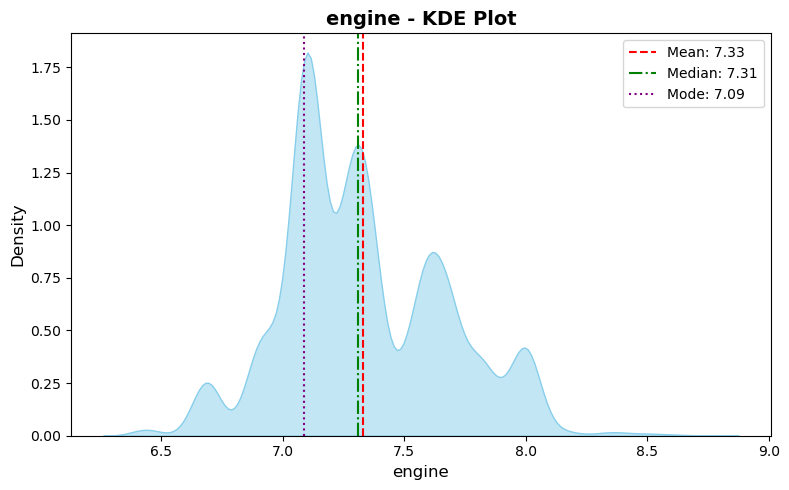

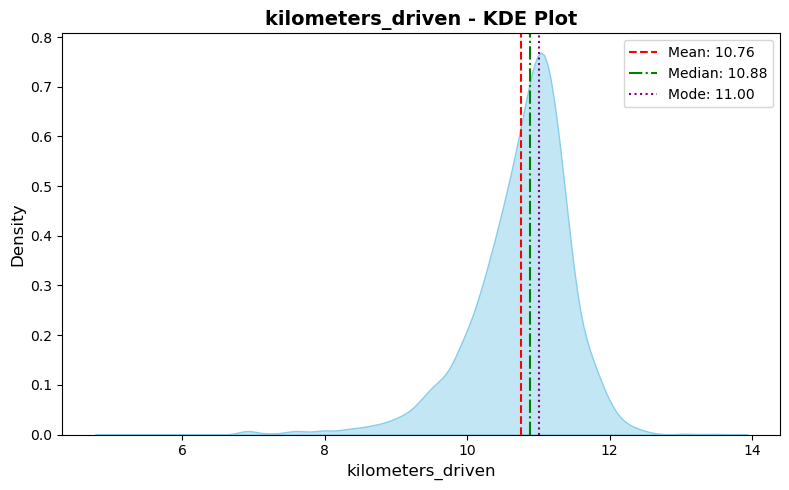

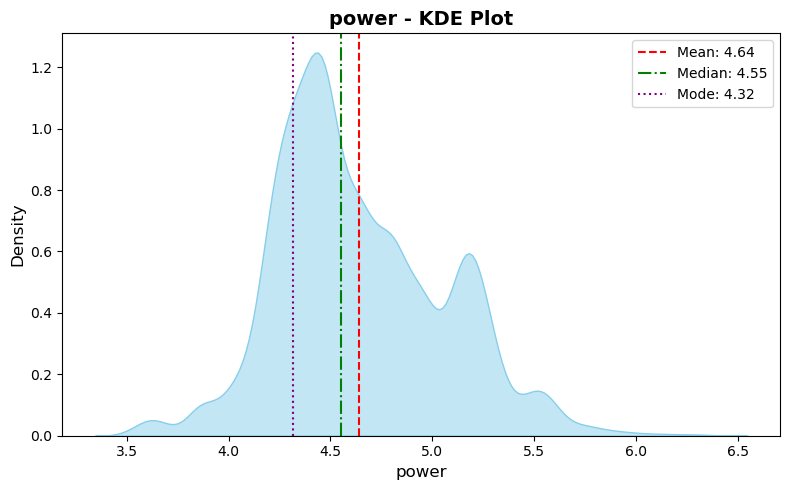

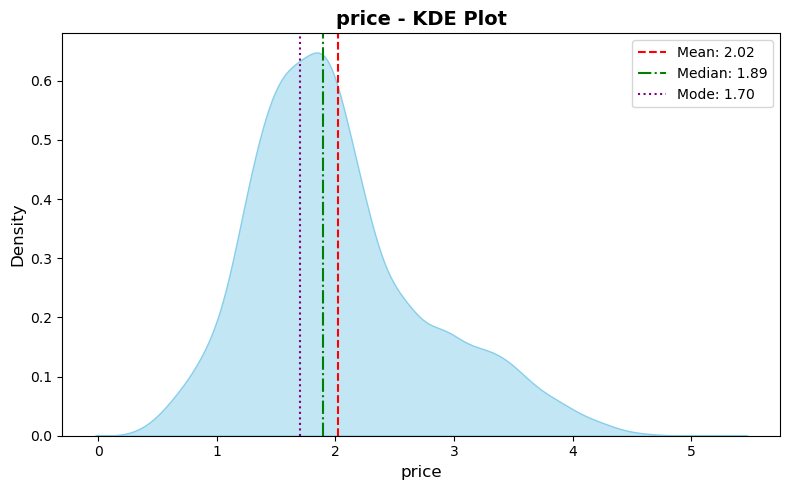

In [406]:
skewed_cols = ['engine', 'kilometers_driven', 'power', 'price']
for col in skewed_cols:
    data[col] = np.log1p(data[col])

    
for col in skewed_cols:
    plt.figure(figsize=(8, 5))
    
    sns.kdeplot(data[col].dropna(), fill=True, color="skyblue", alpha=0.5)
    
    # Mean, median, and mode
    mean_val = data[col].mean()
    median_val = data[col].median()
    mode_val = data[col].mode()[0]
    plt.axvline(mean_val, color="red", linestyle="--", linewidth=1.5, label=f"Mean: {mean_val:.2f}")
    plt.axvline(median_val, color="green", linestyle="-.", linewidth=1.5, label=f"Median: {median_val:.2f}")
    plt.axvline(mode_val, color="purple", linestyle=":", linewidth=1.5, label=f"Mode: {mode_val:.2f}")
    
    # Titles & labels
    plt.title(f"{col} - KDE Plot", fontsize=14, fontweight="bold")
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

## Multivariate Analysis
### Correlation Analysis

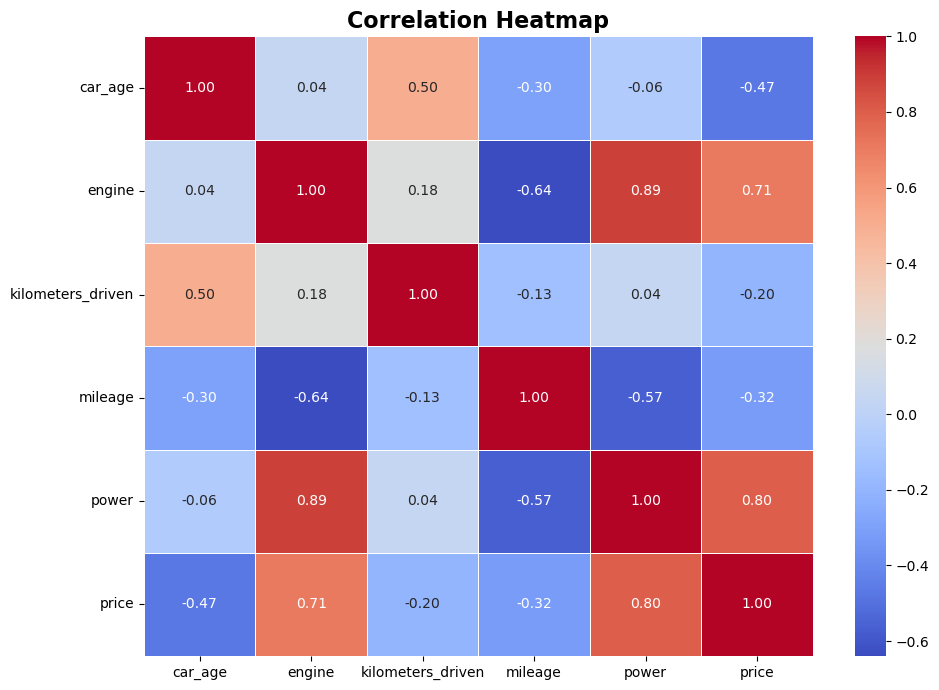

In [407]:
# Calculate correlation matrix
corr_matrix = data[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm",linewidths=0.5)

plt.title("Correlation Heatmap", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

The engine and power variables were highly positively correlated. In the context of vehicles, the bigger the engine size the more powerful is the vehicle. Therefore the power variable will also be dropped.

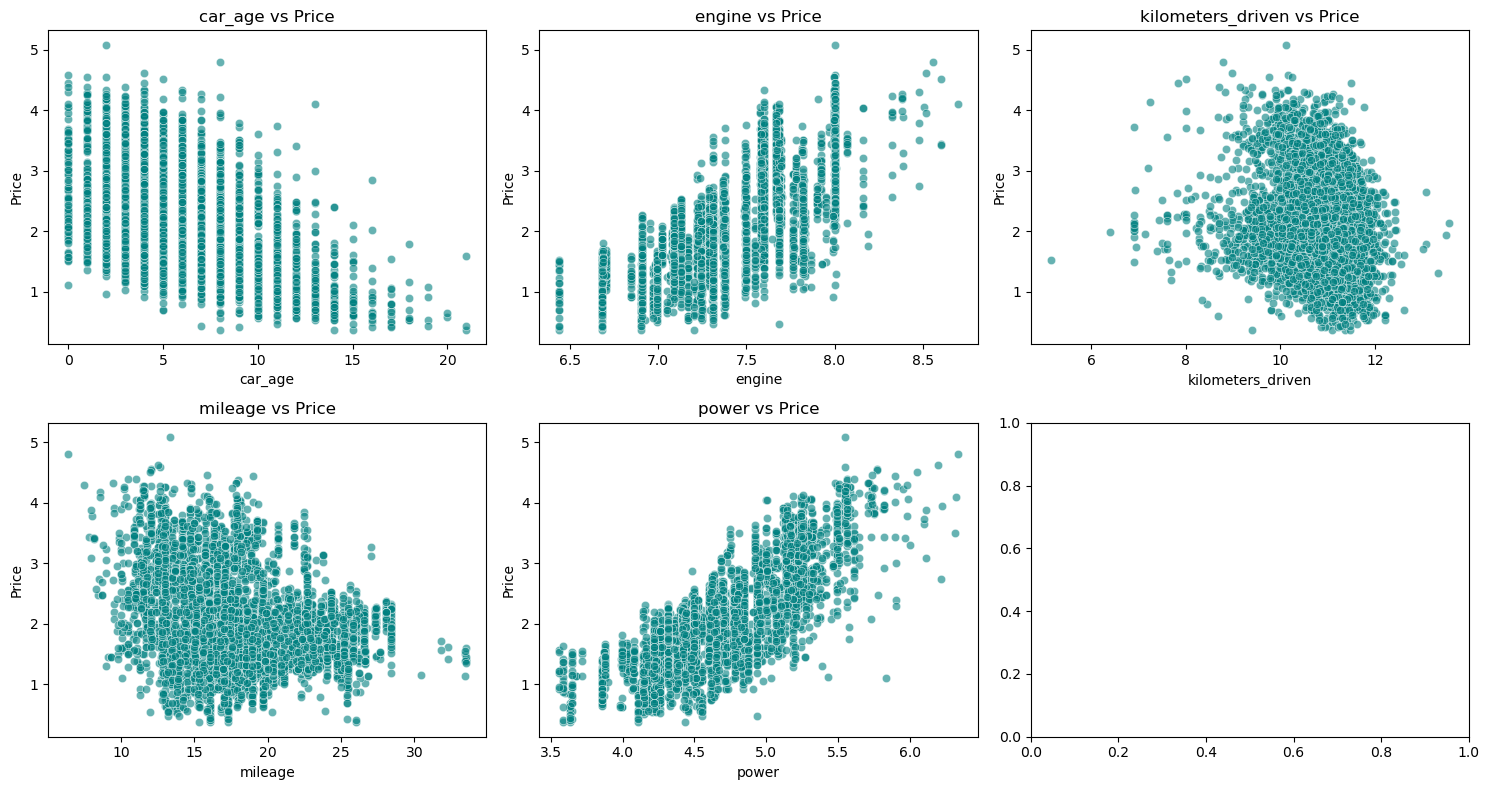

In [408]:
num_cols = ['car_age', 'engine', 'kilometers_driven', 'mileage', 'power']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.scatterplot(x=data[col], y=data['price'], ax=axes[i], alpha=0.6, color='teal')
    axes[i].set_title(f'{col} vs Price')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price')

plt.tight_layout()
plt.show()


In [409]:
data.to_csv("cleaned_used_cars_data.csv")

## Data Preparation

### Creating a clone dataset

In [410]:
df = data.copy()

In [411]:
df.head()

,name,location,year,kilometers_driven,fuel_type,transmission,owner_type,mileage,engine,power,seats,price,make,model,region,car_age,mileage_unit,car_name
0,Maruti Wagon R LXI CNG,Mumbai,2010,11.184435,CNG,Manual,First,26.60,6.906755,4.080246,5.0,1.011601,Maruti,Wagon,West,9,km/kg,Maruti Wagon
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,10.621352,Diesel,Manual,First,19.67,7.367077,4.845761,5.0,2.602690,Hyundai,Creta,West,4,kmpl,Hyundai Creta
2,Honda Jazz V,Chennai,2011,10.736418,Petrol,Manual,First,18.20,7.090077,4.496471,5.0,1.704748,Honda,Jazz,South,8,kmpl,Honda Jazz
3,Maruti Ertiga VDI,Chennai,2012,11.373675,Diesel,Manual,First,20.77,7.130099,4.497139,7.0,1.945910,Maruti,Ertiga,South,7,kmpl,Maruti Ertiga
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,10.613271,Diesel,Automatic,Second,15.20,7.585281,4.954418,5.0,2.930660,Audi,A4,South,6,kmpl,Audi A4


In [412]:
df.columns

Index(['name', 'location', 'year', 'kilometers_driven', 'fuel_type',
       'transmission', 'owner_type', 'mileage', 'engine', 'power', 'seats',
       'price', 'make', 'model', 'region', 'car_age', 'mileage_unit',
       'car_name'],
      dtype='object')

### Dropping unnecessary columns

In [413]:
drop_cols = ['name', 'model',  'location',  'year', 'mileage_unit', 'car_name']
df.drop(columns = drop_cols, inplace=True)

In [414]:
df.head()

,kilometers_driven,fuel_type,transmission,owner_type,mileage,engine,power,seats,price,make,region,car_age
0,11.184435,CNG,Manual,First,26.60,6.906755,4.080246,5.0,1.011601,Maruti,West,9
1,10.621352,Diesel,Manual,First,19.67,7.367077,4.845761,5.0,2.602690,Hyundai,West,4
2,10.736418,Petrol,Manual,First,18.20,7.090077,4.496471,5.0,1.704748,Honda,South,8
3,11.373675,Diesel,Manual,First,20.77,7.130099,4.497139,7.0,1.945910,Maruti,South,7
4,10.613271,Diesel,Automatic,Second,15.20,7.585281,4.954418,5.0,2.930660,Audi,South,6


In [415]:
df.make.value_counts()

make
Maruti           1207
Hyundai          1107
Honda             608
Toyota            410
Mercedes-Benz     315
Volkswagen        315
Ford              300
Mahindra          269
BMW               266
Audi              235
Tata              186
Skoda             173
Renault           145
Chevrolet         121
Nissan             91
Land               60
Jaguar             40
Mitsubishi         27
Mini               26
Fiat               26
Volvo              21
Porsche            16
Jeep               15
Datsun             13
Force               3
ISUZU               2
Ambassador          1
Isuzu               1
Bentley             1
Lamborghini         1
Name: count, dtype: int64

In [416]:
make_counts = df['make'].value_counts(normalize=True) * 100  #Calculate the percentage of each make
rare_makes = make_counts[make_counts < 1].index  #Makes with less than 1% occurrence
df['make'] = df['make'].replace(rare_makes, 'Others') # Replace them with 'Others'
df["make"].value_counts()

make
Maruti           1207
Hyundai          1107
Honda             608
Toyota            410
Volkswagen        315
Mercedes-Benz     315
Ford              300
Mahindra          269
BMW               266
Others            253
Audi              235
Tata              186
Skoda             173
Renault           145
Chevrolet         121
Nissan             91
Name: count, dtype: int64

### Outlier Detection & Removal

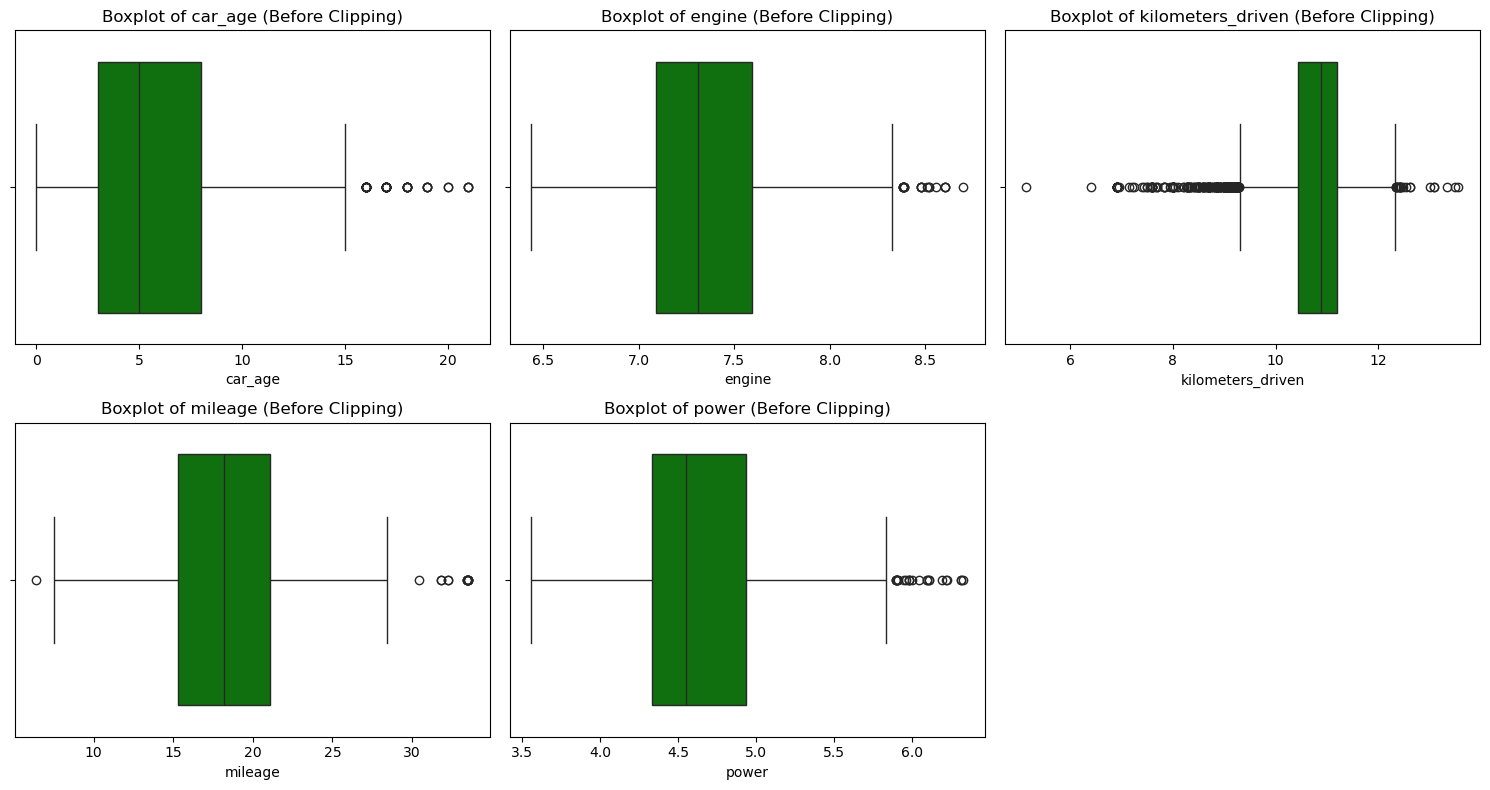

In [417]:
num_cols = ['car_age', 'engine', 'kilometers_driven', 'mileage', 'power']

# Boxplots BEFORE clipping
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], color="green", ax=axes[i])
    axes[i].set_title(f"Boxplot of {col} (Before Clipping)")

fig.delaxes(axes[-1])    
plt.tight_layout()
plt.show()

seats and car_age are ordinal variables which we shall not do any outlier corrections.

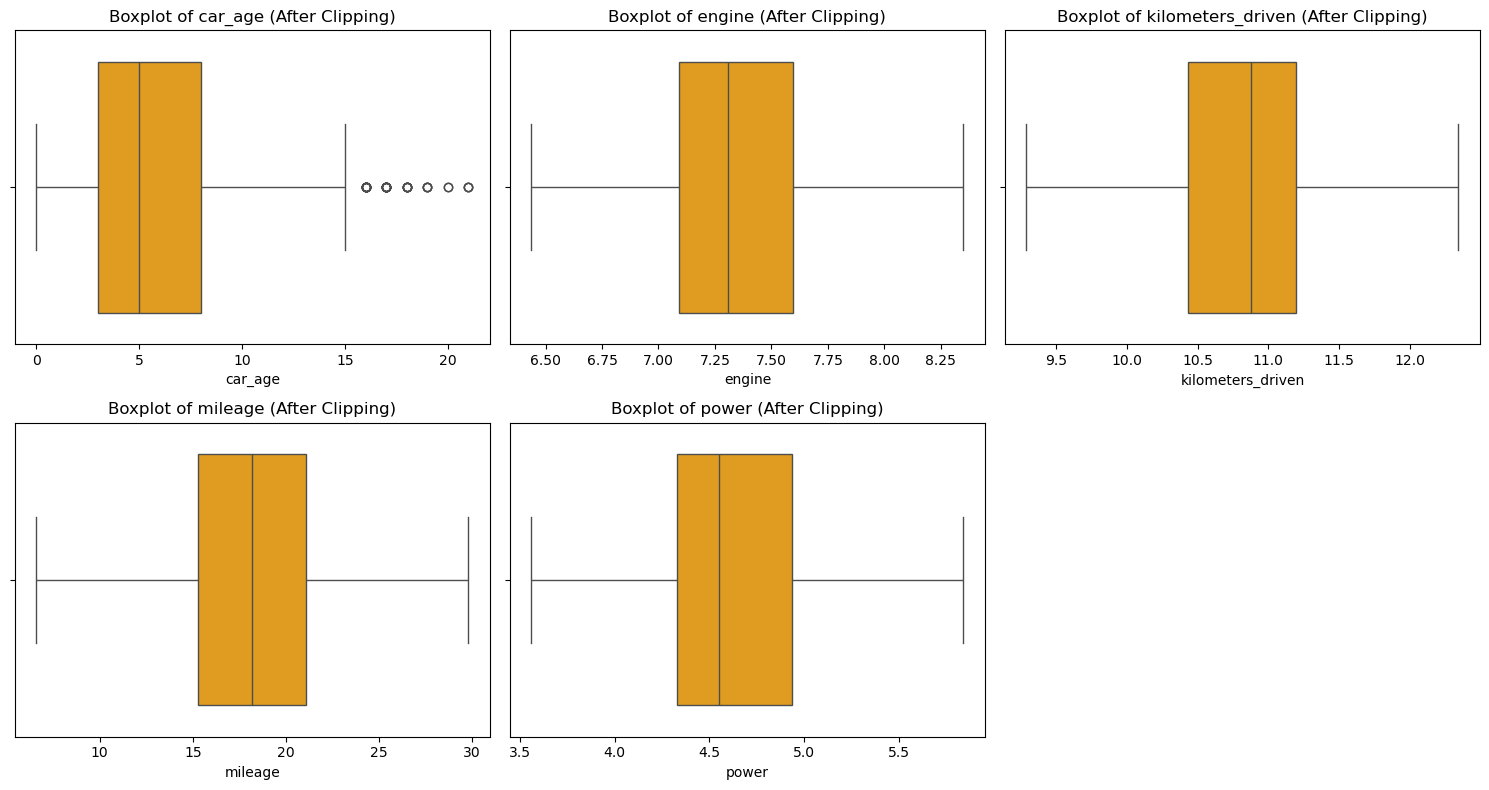

In [432]:
num_cols1 = ['engine', 'kilometers_driven', 'mileage', 'power']

# Outlier clipping using IQR method
for col in num_cols1:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower_bound, upper_bound)

# Boxplots AFTER clipping
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], color="orange", ax=axes[i])
    axes[i].set_title(f"Boxplot of {col} (After Clipping)")
fig.delaxes(axes[-1])       
plt.tight_layout()
plt.show()

### Testing for Multicollinearity using VIF scores
1. If VIF is 1 then there is no correlation among the kth predictor and the remaining predictor variables, and hence the variance of β̂k is not inflated at all.
2. if VIF exceeds 5 or is close to exceeding 5, we say there is moderate VIF and if it is 10 or exceeding 10, it shows signs of high multi-collinearity.

In [419]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
num_cols = ['car_age', 'engine', 'kilometers_driven', 'mileage', 'power', 'seats']

X = df[num_cols]  # num_cols = your numerical predictors list

# Add constant term for intercept
X = sm.add_constant(X)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]

print(vif_data)

             Feature          VIF
0              const  1539.644042
1            car_age     1.778083
2             engine     7.911647
3  kilometers_driven     1.585495
4            mileage     2.129578
5              power     6.603197
6              seats     1.666308


## Encoding Categorical features

In [420]:
cat_cols = ['fuel_type', 'owner_type', 'region', 'transmission', 'make']

df = pd.get_dummies(df, columns = cat_cols, drop_first=True, dtype=float)
df.head()

,kilometers_driven,mileage,engine,power,seats,price,car_age,fuel_type_Diesel,fuel_type_LPG,fuel_type_Petrol,...,make_Mahindra,make_Maruti,make_Mercedes-Benz,make_Nissan,make_Others,make_Renault,make_Skoda,make_Tata,make_Toyota,make_Volkswagen
0,11.184435,26.60,6.906755,4.080246,5.0,1.011601,9,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.621352,19.67,7.367077,4.845761,5.0,2.602690,4,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.736418,18.20,7.090077,4.496471,5.0,1.704748,8,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.373675,20.77,7.130099,4.497139,7.0,1.945910,7,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10.613271,15.20,7.585281,4.954418,5.0,2.930660,6,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Linear Regression

In [421]:
X = df.drop(['price'], axis=1)
y = df[['price']]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in test data =", X_test.shape[0])

Number of rows in train data = 4200
Number of rows in test data = 1801


In [422]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [423]:
# Regression coefficients
coeff_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr.coef_.ravel()})
print( coeff_df)

                      Feature  Coefficient
0           kilometers_driven    -0.100485
1                     mileage    -0.009850
2                      engine     0.283766
3                       power     0.693271
4                       seats     0.016680
5                     car_age    -0.085541
6            fuel_type_Diesel     0.111952
7               fuel_type_LPG     0.001690
8            fuel_type_Petrol    -0.084738
9   owner_type_Fourth & Above     0.025141
10          owner_type_Second    -0.053477
11           owner_type_Third    -0.069437
12               region_North     0.162235
13               region_South     0.269796
14                region_West     0.156462
15        transmission_Manual    -0.123378
16                   make_BMW    -0.046421
17             make_Chevrolet    -0.721341
18                  make_Ford    -0.539633
19                 make_Honda    -0.531357
20               make_Hyundai    -0.476428
21              make_Mahindra    -0.622070
22         

In [424]:
print("Training R²:", r2_score(y_train, y_train_pred))
print("Testing R²:", r2_score(y_test, y_test_pred))

print("Training RMSE:", mean_squared_error(y_train, y_train_pred, squared=False))
print("Testing RMSE:", mean_squared_error(y_test, y_test_pred, squared=False))

print("Training MAE:", mean_absolute_error(y_train, y_train_pred))
print("Testing MAE:", mean_absolute_error(y_test, y_test_pred))

# Cross validation
cv_scores = cross_val_score(lr, X, y, cv=10, scoring='r2')
print("10-Fold CV R² Scores:", cv_scores)
print("Mean CV R²:", np.mean(cv_scores))

Training R²: 0.9192750916080332
Testing R²: 0.916394848960999
Training RMSE: 0.21464494036209064
Testing RMSE: 0.20901154369812197
Training MAE: 0.1607834713671205
Testing MAE: 0.1509148603022344
10-Fold CV R² Scores: [0.92965747 0.92216185 0.91526705 0.92462072 0.92885128 0.88920098
 0.89939131 0.92432391 0.92067007 0.9129855 ]
Mean CV R²: 0.9167130144043527


#### Linear Regression Assumptions
- No Multicollinearity
- Linearity of variables
- Normality of residuals(error terms)
- No autocorrelation (Independence of Residuals)
- No Heteroscedacity

### Linearity
Checking if the relationship between predictors and target is linear.

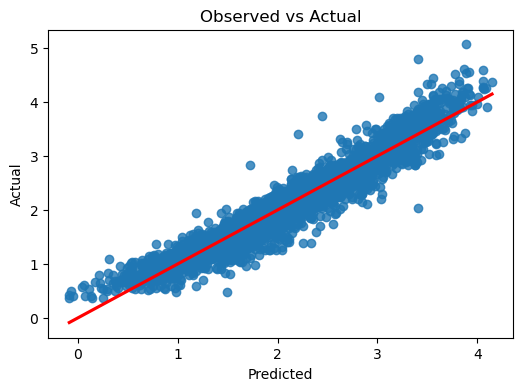

In [425]:
plt.figure(figsize=(6, 4))
sns.regplot(x= y_train_pred, y=y_train, line_kws={"color": "red"})
plt.title('Observed vs Actual')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Normality of Error terms

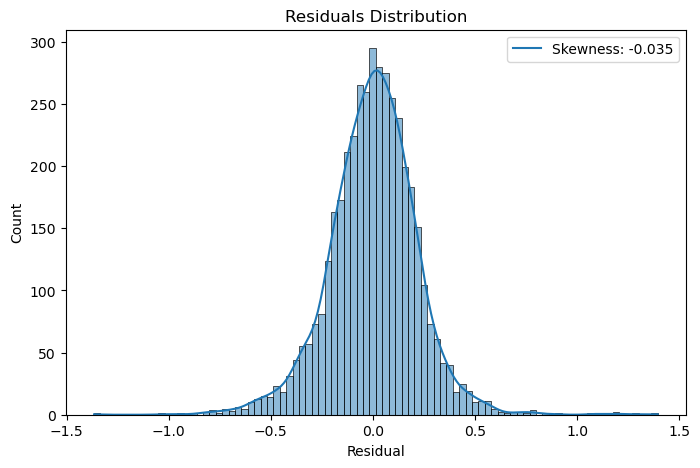

Skewness of the residuals:  -0.03470436566441535
Mean of the residuals:  2.266969680758415e-16


In [426]:
# Residual analysis
residuals = y_train - y_train_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color='skyblue', label=None)
plt.title("Residuals Distribution")
plt.xlabel("Residual")
skew_val = float(residuals.skew())
plt.legend([f"Skewness: {skew_val:.3f}"])
plt.show()

print("Skewness of the residuals: ", skew_val)
print("Mean of the residuals: ", float(residuals.mean()))

The residuals follow a normal distribution.

### No autocorrelation
Checking if the residuals are independent.

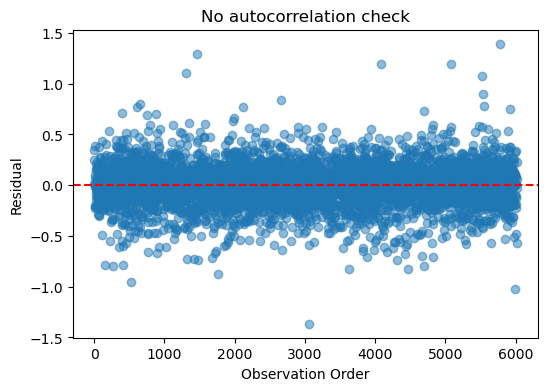

In [427]:
# Method 1
plt.figure(figsize=(6,4))
plt.plot(residuals, marker='o', linestyle='', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Observation Order")
plt.ylabel("Residual")
plt.title("No autocorrelation check")
plt.show()

No clear pattern implies independence of the residuals.

In [428]:
# Method 2 - Durbin-Watson test
from statsmodels.stats.stattools import durbin_watson
print("Durbin-Watson statistic:", durbin_watson(residuals))


Durbin-Watson statistic: [1.9584484]


Value close to 2 means independence (0–4 range) & <1 or >3 indicates strong autocorrelation.

### Homoscedasticity
Constant variance of residuals across all levels of predictors.

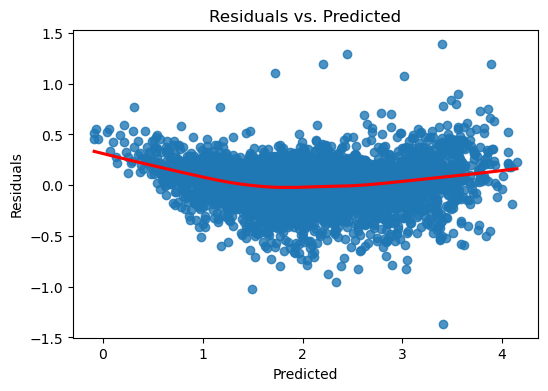

In [429]:
plt.figure(figsize=(6,4))
sns.regplot(x= np.ravel(y_train_pred), y =np.ravel(residuals), lowess=True, line_kws={'color': 'red'})
plt.title("Residuals vs. Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

The variance of the residuals relatively constant with Prediction which implies that Homoscedasticity exists.

## Decision Tree

In [430]:
dt= DecisionTreeRegressor(max_depth=6, random_state=42, min_samples_split=50)
dt.fit(X_train, y_train)

y_train_pred_dt = dt.predict(X_train)
y_test_pred_dt = dt.predict(X_test)

print("Decision Tree R² (Train):", r2_score(y_train, y_train_pred_dt))
print("Decision Tree R² (Test):", r2_score(y_test, y_test_pred_dt))
print("Decision Tree RMSE (Test):", mean_squared_error(y_test, y_test_pred_dt, squared=False))

cv_scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='r2')
np.mean(cv_scores)

Decision Tree R² (Train): 0.9023085477123898
Decision Tree R² (Test): 0.8628504279862648
Decision Tree RMSE (Test): 0.2677016101070645


0.877799506898822

## Random Forest

In [431]:
rf= RandomForestRegressor(n_estimators=100, min_samples_split=60, random_state=42)
rf.fit(X_train, y_train)

y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

print("Random Forest R² (Train):", r2_score(y_train, y_train_pred_rf))
print("Random Forest R² (Test):", r2_score(y_test, y_test_pred_rf))
print("Random Forest RMSE (Test):", mean_squared_error(y_test, y_test_pred_rf, squared=False))

cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
np.mean(cv_scores)

Random Forest R² (Train): 0.9338045240607595
Random Forest R² (Test): 0.9015161621470573
Random Forest RMSE (Test): 0.22684866988957175


0.9095342681906347